In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions


model = VGG16(weights='imagenet', include_top=True) #Load alredy pre-trained model
model.summary() #Print a list of layers with all the details

2024-04-08 08:19:07.949375: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 08:19:08.282655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-08 08:19:08.284862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 08:19:09.870368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


553467096/553467096 [==============================] - 639s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

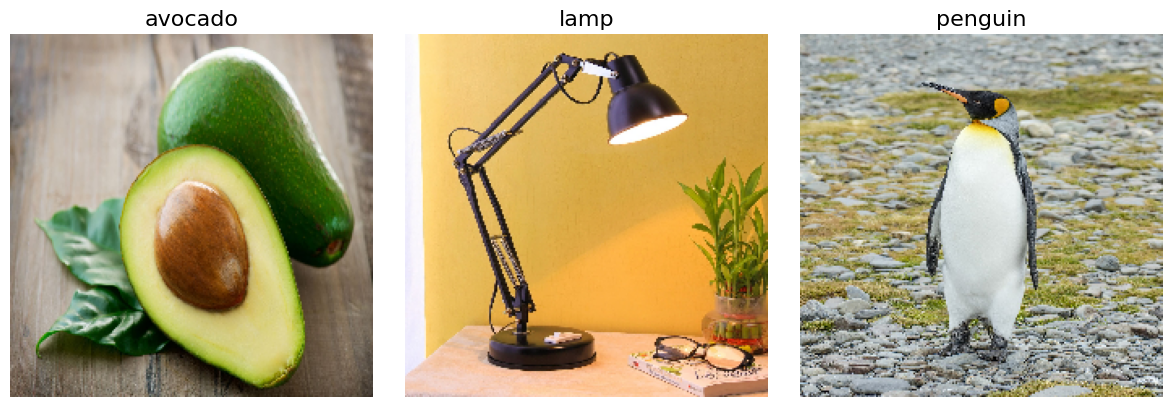

In [2]:
# Assign image titles for your images
image_titles = ['avocado', 'lamp', 'penguin']

# Load images and reshape them
img1 = load_img('/home/hyunmila/Documents/repos/um/avocado.jpg', target_size=(224, 224))
img2 = load_img('/home/hyunmila/Documents/repos/um/lamp.jpg', target_size=(224, 224))
img3 = load_img('/home/hyunmila/Documents/repos/um/penguin.jpg', target_size=(224, 224))
#We resize the images into size 224 x 224, as the model prefers those sizes. However, if your images are smaller, you can change those values a little bit.

# Convert them to a Numpy array
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Predict the output (probabilities) of the layer, corresponding to an image
import tensorflow as tf
preds = model.predict(X)
best_class = np.argmax(preds, axis=1)

print('Predicted:', decode_predictions(preds, top=3)[0]) 
print('Predicted:', decode_predictions(preds, top=3)[1]) 
print('Predicted:', decode_predictions(preds, top=3)[2]) 

1/1 [==============================] - 1s 776ms/step
Predicted: [('n07716358', 'zucchini', 0.4589705), ('n07718472', 'cucumber', 0.30507094), ('n07753113', 'fig', 0.11749975)]
Predicted: [('n04380533', 'table_lamp', 0.6131141), ('n04522168', 'vase', 0.1413701), ('n03637318', 'lampshade', 0.042932)]
Predicted: [('n02056570', 'king_penguin', 1.0), ('n01847000', 'drake', 5.3700355e-10), ('n01855672', 'goose', 2.3740648e-10)]


In [24]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [25]:
def visualise_heatmap(map):
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    for i, title in enumerate(image_titles):
        heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
        ax[i].set_title(title, fontsize=16)
        ax[i].imshow(images[i])
        ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

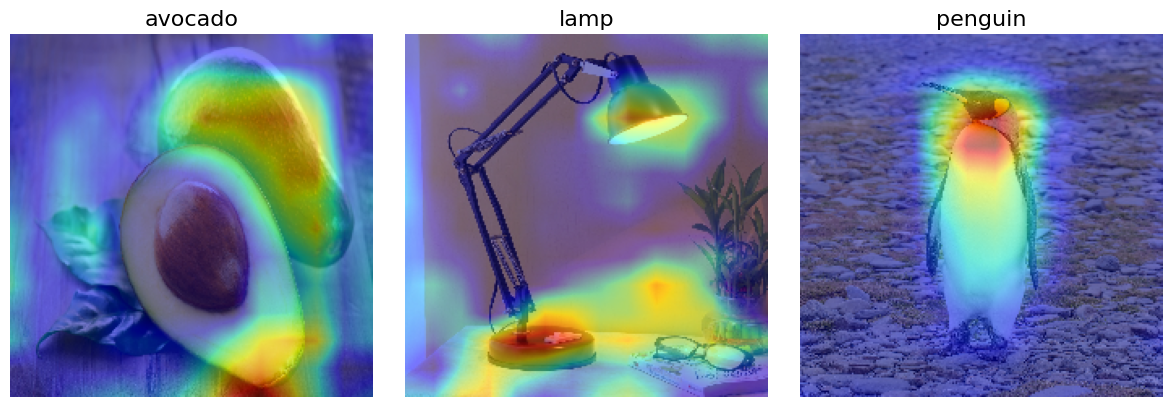

In [26]:
replace2linear = ReplaceToLinear()
score = CategoricalScore(list(best_class))

gradcam = Gradcam(model,
                model_modifier=replace2linear,
                clone=True)

cam = gradcam(score,
            X,
            penultimate_layer=-1)

visualise_heatmap(cam)

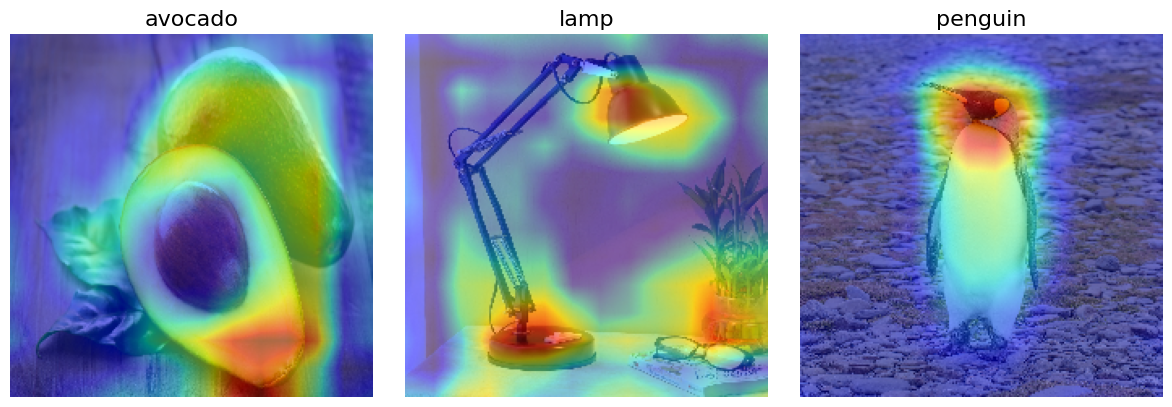

In [27]:
gradcam = GradcamPlusPlus(model,
                        model_modifier=replace2linear,
                        clone=True)

cam = gradcam(score,
            X,
            penultimate_layer=-1)

visualise_heatmap(cam)

2024-04-08 08:56:34.908267: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 924844032 exceeds 10% of free system memory.


48/48 [==============================] - 429s 9s/step


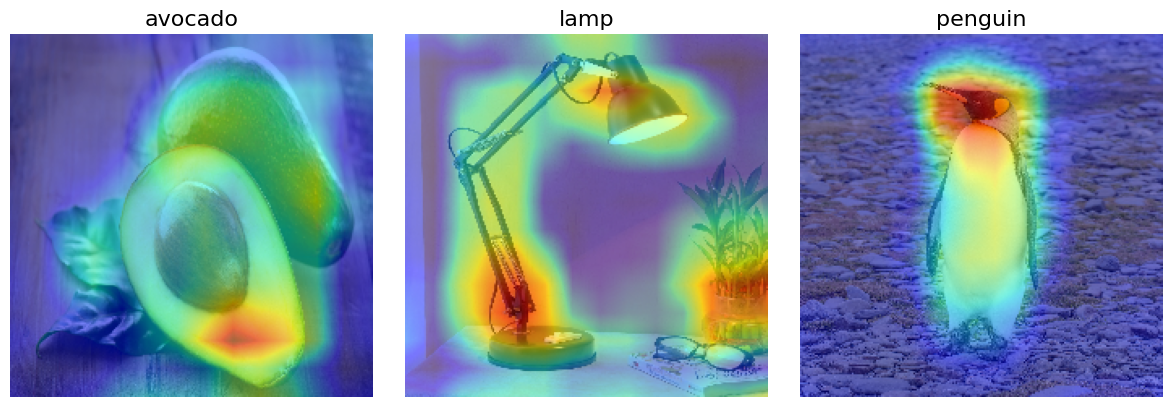

In [28]:
scorecam = Scorecam(model)
cam = scorecam(score, X, penultimate_layer=-1)
visualise_heatmap(cam)

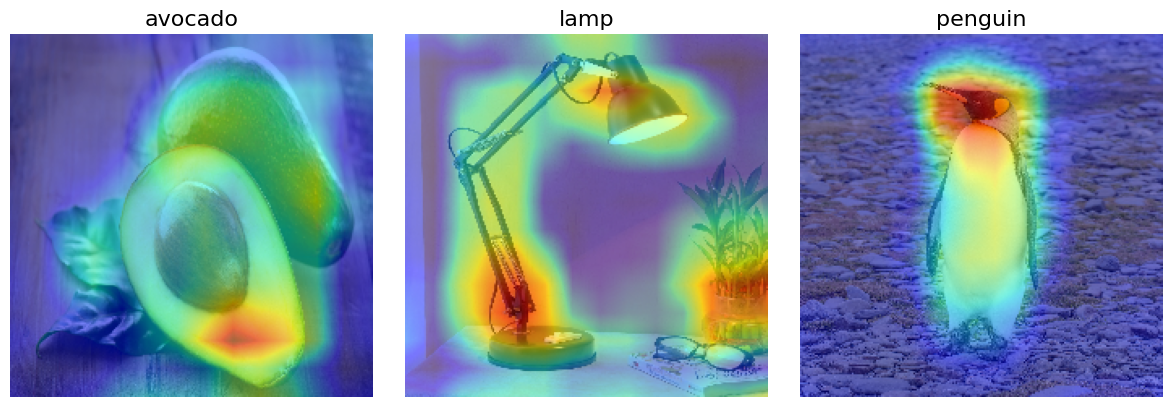

In [29]:
saliency = Saliency(model, model_modifier=replace2linear, clone=True)
saliency_map = saliency(score, X)
visualise_heatmap(saliency_map)

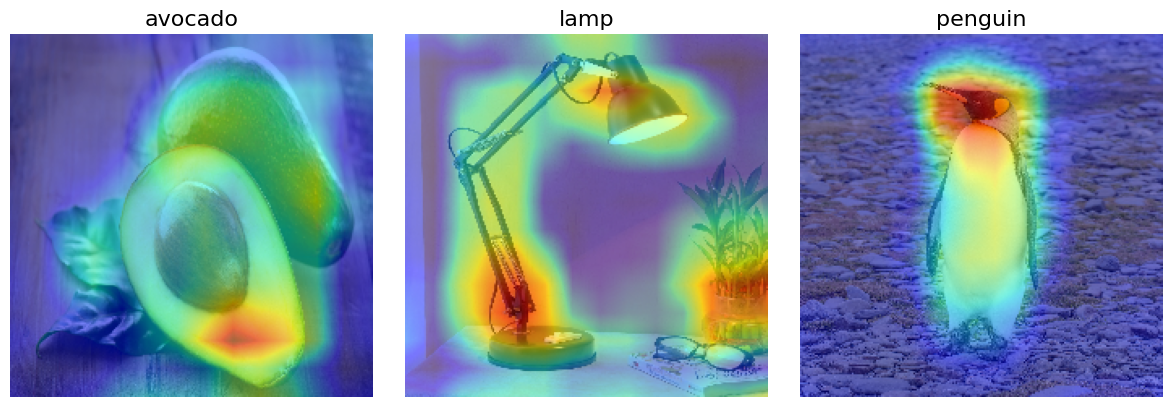

In [30]:
saliency_map = saliency(score, X, smooth_samples=20, smooth_noise=0.20)
visualise_heatmap(saliency_map)

1/1 [==============================] - 0s 488ms/step


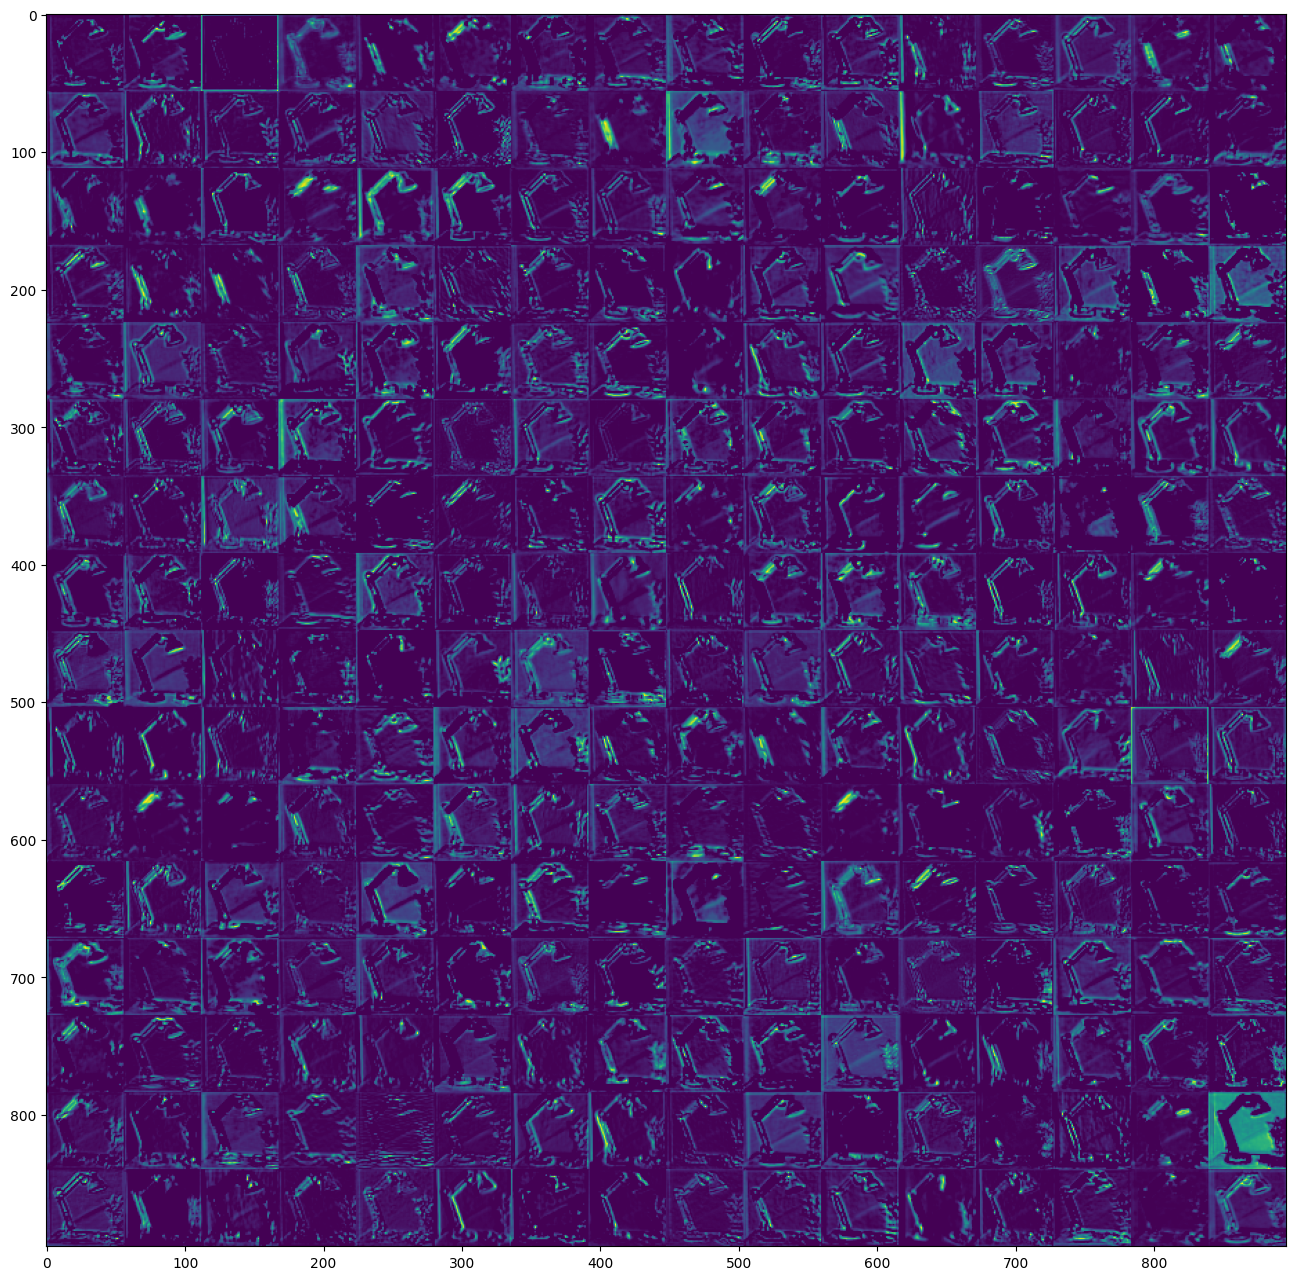

In [39]:
layer_outputs = [layer.output for layer in model.layers] #Loop through the model defined in the beginning to access outputs of individual layers
activation_model = models.Model(model.input, layer_outputs)

X_reshaped = X[1].reshape((1,224,224,3))
#TODO take one image and reshape it into size (1,224,224,3)
activations = activation_model.predict(X_reshaped)
#TODO use the predict function on the activation model to get the intermediate activations

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name == 'block3_conv1':
    #TODO Specify the name of the layer that you want to see. Choose one name from the model summary we printed in the beginning
        number_of_feature_maps = layer_activation.shape[-1]
        feature_map_shape = layer_activation.shape[1]
        n_cols = number_of_feature_maps // images_per_row
        display_grid = np.zeros((feature_map_shape * n_cols, images_per_row * feature_map_shape))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image /= np.max(channel_image)
                display_grid[col * feature_map_shape : (col + 1) * feature_map_shape, row * feature_map_shape : (row + 1) * feature_map_shape] = channel_image
        scale = 1. / feature_map_shape
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.imshow(display_grid, aspect='auto', cmap='viridis')